In [2]:
import pandas as pd
import numpy as np
import requests
from umap import UMAP
from tqdm import tqdm_notebook
import pickle

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Loading already pre-trained publics embeddings

In [3]:
%%time

# https://drive.google.com/file/d/12KOF08jt0BVtnNDLAkMPoUiayIrhJV4j/view?usp=sharing
publics_emb = pd.read_csv('starspace_vk_publics_dim128.zip', sep='\t', header=None)
publics_emb.set_index(0, inplace=True)
publics_emb.index = publics_emb.index.map(lambda x: int(x.replace('p_','')))
publics_emb.sort_index(inplace=True)
publics_ids = set(publics_emb.index)

CPU times: user 14.1 s, sys: 1.56 s, total: 15.6 s
Wall time: 15.8 s


In [4]:
# you can get your accsess_token using https://vkhost.github.io/
# or official guidline https://vk.com/dev/access_token

ACCESS_TOKEN = '___INSERT___YOUR__TOKEN___'

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
def search_groups(ids):
    if type(ids) is not list:
        ids = [ids]
    ids = list(map(str, ids))
    result = list()
    for r in chunks(ids, 400):
        result.extend(search_groups_(r))
    return result
    
def search_groups_(ids):
    url='https://api.vk.com/method/groups.getById?fields=members_count&group_ids={0}&v=5.61&access_token={1}'.format(','.join(ids), ACCESS_TOKEN)
    response = requests.get(url)
    if response.status_code == 200:
        json_result = response.json()
        return json_result['response']
    return None

def get_public_id(public_url):
    if isinstance(public_url, int) or public_url.isdigit():
        return int(public_url)
    else:
        if 'public' in public_url:
            public_url = public_url.replace('public','')
        if '/' in public_url:
            public_url = public_url.split('/')[3]
        return search_groups_([public_url])[0]['id']

def show_groups_info(responses):
    for item in responses:
        print('http://vk.com/public%d %s'%(item['id'], item['name']))

def get_user_subscriptions(user_id):
    url = 'https://api.vk.com/method/users.getSubscriptions?user_id={0}&v=5.63&access_token={1}'.format(user_id, ACCESS_TOKEN)
    response = requests.get(url, timeout=30)
    if response.status_code == 200:
        return response.json()['response']
    return None

def get_publics_embedings(user_subscriptions):
    idx = publics_emb.index.searchsorted(user_subscriptions)
    return publics_emb.iloc[idx].sum(axis=0)

def get_public_vector(public_id):
    return publics_emb.loc[public_id].values.reshape((1, -1))

def get_recommendations(vector, top_n=5, except_subscriptions={}):
    r = cosine_similarity(publics_emb.values, vector)
    indexes = publics_emb.iloc[r.argsort(axis=0)[::-1].reshape(-1)[:top_n]].index
    indexes = [x for x in indexes if x not in except_subscriptions]
    return indexes

# Measuring similarity between VK publics

In [5]:
TEST_PUBLIC = 'https://vk.com/datascience'
SHOW_TOP_N = 20

# retrieving public ID from URL
public_id = get_public_id(TEST_PUBLIC)

# extracting already learned 128D vector (if TEST_PUBLIC in the index)
public_vector = get_public_vector(public_id)

# calculating similarity between TEST public and ALL others publics
publics_similarity = cosine_similarity(publics_emb.values, public_vector) 

# sort ALL publics by similarity and take only TOP_N similar publics
most_similar_indexes = publics_similarity.argsort(axis=0)[::-1].reshape(-1)[:SHOW_TOP_N]

# take exact similarity values
most_similar_values = publics_similarity[most_similar_indexes]

# convert internal indexes into VK indexes
most_similar_publics_ids = publics_emb.iloc[most_similar_indexes].index

# retrieval public information (like public name)
most_similar_publics_info = search_groups(most_similar_publics_ids)


# show most similar publics
for public_info, public_similarity in zip(most_similar_publics_info, most_similar_values):
    print('[%f] https://vk.com/public%d %s'%(public_similarity, public_info['id'], public_info['name']))

[1.000000] https://vk.com/public72870626 ModelOverfit
[0.718515] https://vk.com/public49815762 Data Mining Labs
[0.654209] https://vk.com/public110085011 TensorFlow
[0.590193] https://vk.com/public34737049 Сколковский институт науки и технологий
[0.585816] https://vk.com/public31319658 Rusbase
[0.520601] https://vk.com/public131489096 Мемы про Машинное Обучение для Взрослых Мужиков
[0.501846] https://vk.com/public34171146 BCC|Bauman Career Club
[0.483260] https://vk.com/public123851409 Тинькофф Финтех
[0.478469] https://vk.com/public98006063 Программа стажировок SafeBoard
[0.469668] https://vk.com/public43157549 IT-Events
[0.467102] https://vk.com/public69839157 Библиотека программиста [eng]
[0.461774] https://vk.com/public30767675 Фонд Сколково
[0.455077] https://vk.com/public67401618 Вычислительная экономика
[0.451318] https://vk.com/public67968050 КИВИ HSE
[0.450249] https://vk.com/public36244753 Pareto
[0.449072] https://vk.com/public68022762 FinExecutive
[0.440781] https://vk.com/

# Making recommendations for a user

In [6]:
TEST_USER_ID = 16184332

# retrieving test user subscriptions (publics)
user_subscriptions_ids = get_user_subscriptions(TEST_USER_ID)['groups']['items']

# filter publics by checking if the public is already learned
user_subscriptions_ids = list(filter(lambda x: x in publics_ids, user_subscriptions_ids))
user_subscriptions_name = [x['name'] for x in search_groups(user_subscriptions_ids)]

if len(user_subscriptions_ids) == 0:
    raise Exception("There are no subsriptions")

# extracting vectors for all user subscriptions (publics)
user_subscriptions_embeddings = np.vstack([get_public_vector(x) for x in user_subscriptions_ids])

### Visualizing user subscriptions

CPU times: user 4.98 s, sys: 80 ms, total: 5.06 s
Wall time: 5.25 s


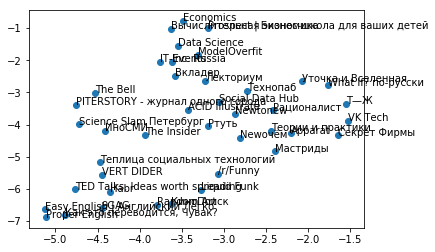

In [7]:
%%time
# reduce dimension of user subscriptions for visualization
umap_dim_reductor = UMAP(n_neighbors=5, metric='cosine') # we also can use TSNE
reduced_vectors = umap_dim_reductor.fit_transform(user_subscriptions_embeddings)

# visualization
fig, ax = plt.subplots()
ax.scatter(reduced_vectors[:,0], reduced_vectors[:,1])

for i, txt in enumerate(user_subscriptions_name):
    ax.annotate(txt, reduced_vectors[i])

### Calculating most similar publics to the user

In [8]:
# getting *user vector* by summing all embeddings
user_representation = np.sum(user_subscriptions_embeddings, axis=0).reshape(1, -1)

# the same steps as in previous
# calculating similarity between TEST public and ALL others publics
publics_similarity = cosine_similarity(publics_emb.values, user_representation) 

# sort ALL publics by similarity and take only TOP_N similar publics
most_similar_indexes = publics_similarity.argsort(axis=0)[::-1].reshape(-1)[:SHOW_TOP_N]

# take exact similarity values
most_similar_values = publics_similarity[most_similar_indexes]

# convert internal indexes into VK indexes
most_similar_publics_ids = publics_emb.iloc[most_similar_indexes].index

# retrieval public information (like public name)
most_similar_publics_info = search_groups(most_similar_publics_ids)


# show most similar publics
for public_info, public_similarity in zip(most_similar_publics_info, most_similar_values):
    print('[%f] https://vk.com/public%d %s'%(public_similarity, public_info['id'], public_info['name']))

[0.673578] https://vk.com/public49815762 Data Mining Labs
[0.618836] https://vk.com/public54799175 Лекториум
[0.598495] https://vk.com/public31319658 Rusbase
[0.598103] https://vk.com/public72870626 ModelOverfit
[0.597527] https://vk.com/public67977655 Newtonew
[0.574183] https://vk.com/public77270571 Geektimes
[0.562063] https://vk.com/public80512191 Newочём
[0.559947] https://vk.com/public96047932 Мастриды
[0.555817] https://vk.com/public110085011 TensorFlow
[0.547429] https://vk.com/public64915591 Spark
[0.534682] https://vk.com/public91933860 N + 1
[0.534682] https://vk.com/public16466790 Теории и практики
[0.519229] https://vk.com/public132769220 Inc. Russia
[0.505311] https://vk.com/public69839157 Библиотека программиста [eng]
[0.504930] https://vk.com/public65688570 Less Wrong по-русски
[0.504753] https://vk.com/public34737049 Сколковский институт науки и технологий
[0.504657] https://vk.com/public30825867 Start Fellows
[0.503500] https://vk.com/public9471321 Курилка Гутенберга 

# Visualization of semantic space for top 10000 VK publics 

Visualization of semantic space for top 10000 VK publics <br>
https://puzer.github.io/projector/

# Predicting user gender based on subscriptions

### Loading a random sample of users

In [9]:
# https://drive.google.com/open?id=1XsFcvnMr6NAIZD78brofEU2o8tYXoVQs
users_profile = pickle.load(open('users_sample.pkl', 'rb'))

print('Users in sample:', len(users_profile))
print('One example:')
next(iter(users_profile.values()))

Users in sample: 100000
One example:


{'date': 1986,
 'sex': 2,
 'subscriptions': [25613643,
  32593073,
  73514560,
  119842966,
  6359845,
  42697493,
  47703317,
  99846159]}

### EDA (exploratory data analysis)

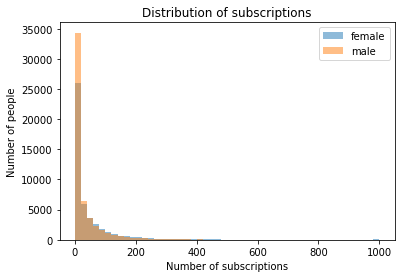

In [13]:
plt.hist([len(v['subscriptions']) for k,v in users_profile.items() if v['sex']==1], bins=50, label='female', alpha=0.5)
plt.hist([len(v['subscriptions']) for k,v in users_profile.items() if v['sex']==2], bins=50, label='male', alpha=0.5)

plt.legend()
plt.title('Distribution of subscriptions')
plt.xlabel('Number of subscriptions')
plt.ylabel('Number of people')
plt.show()

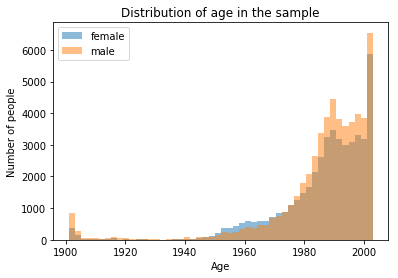

In [14]:
plt.hist([v['date'] for k,v in users_profile.items() if v['sex']==1], bins=50, label='female', alpha=0.5)
plt.hist([v['date'] for k,v in users_profile.items() if v['sex']==2], bins=50, label='male', alpha=0.5)

plt.title('Distribution of age in the sample')
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.legend()
plt.show()

### Most popular publics

In [15]:
from itertools import chain
from collections import Counter

all_subscriptions = list(chain(*[v['subscriptions'] for k,v in users_profile.items()]))
publics_frequency = Counter(all_subscriptions)

show_groups_info(search_groups(list(list(zip(*publics_frequency.most_common(10)))[0])))

http://vk.com/public27895931 Новая Музыка 2018 | Новинки
http://vk.com/public45441631 ПРИКОЛЫ | Смеяка
http://vk.com/public43215063 Киномания | Новинки 2018
http://vk.com/public26419239 Смейся до слёз :D
http://vk.com/public22798006 Киномания
http://vk.com/public57846937 MDK
http://vk.com/public23064236 Четкие Приколы
http://vk.com/public12382740 ЁП
http://vk.com/public58170807 КиноКайф - Лучшие фильмы
http://vk.com/public31836774 Чёткие приколы


### Preprocessing training data

In [11]:
from sklearn.feature_extraction import DictVectorizer

target = list()
users_subscriptions = list()

for k,v in users_profile.items():
    user_publics = publics_ids & set( v['subscriptions'])
    if len(user_publics) >= 5:
        target.append(v['sex'] == 2) # is it a male ?
        users_subscriptions.append({uid:1 for uid in user_publics})

dict_vectorizer = DictVectorizer()
X_data = dict_vectorizer.fit_transform(users_subscriptions)
dict_vectorizer.inverse_vocabulary_ = {v:k for k,v in dict_vectorizer.vocabulary_.items()}

y_data = np.array(target)

### Training model

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=42)

#X_train = X_train[:100]
#y_train = y_train[:100]

clf = SGDClassifier(loss='log', penalty = 'l2', class_weight='balanced', max_iter = 5)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Evaluating model performance

In [13]:
print('Accuracy:', clf.score(X_test, y_test))
print('AUC-ROC:', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

Accuracy: 0.8902908035895014
AUC-ROC: 0.9563179401792606


### Analysing of model performance

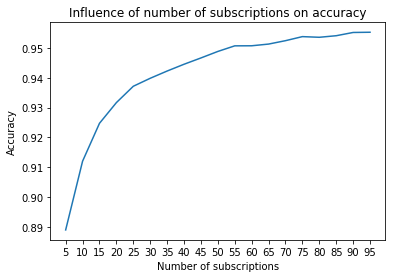

In [20]:
nb_of_subscriptions = X_test.sum(axis=1).A.reshape(-1)

thresholds = list(range(5, 100, 5))
accuracy_scores = list()

for nb_of_subscriptions_threshold in thresholds:
    mask = nb_of_subscriptions >= nb_of_subscriptions_threshold
    accuracy_scores.append(clf.score(X_test[mask], y_test[mask]))
    
plt.plot(thresholds, accuracy_scores)
plt.ylabel('Accuracy')
plt.xlabel('Number of subscriptions')
plt.title('Influence of number of subscriptions on accuracy')
plt.xticks(thresholds)
plt.show()

### Analysing model parameters

In [21]:
model_params_args = clf.coef_[0].argsort()

most_feminine_publics = [dict_vectorizer.inverse_vocabulary_[x] for x in model_params_args[:10]]
most_masculine_publics =  [dict_vectorizer.inverse_vocabulary_[x] for x in model_params_args[-10:]]

print('The most masculine publics')
show_groups_info(search_groups(most_masculine_publics))

print('\n\nThe most feminine publics')
show_groups_info(search_groups(most_feminine_publics))

The most masculine publics
http://vk.com/public51812607 Российская Премьер-Лига
http://vk.com/public68988957 МЯСО | Мужская кухня
http://vk.com/public23783750 AUTO
http://vk.com/public90060110 АВТО
http://vk.com/public43726747 Джентльмен Club
http://vk.com/public36220599 Бодибилдинг | Спорт | ЗОЖ
http://vk.com/public27570276 Мастерская "220 Вольт"
http://vk.com/public56433000 Рыбалка
http://vk.com/public101573653 Opegit Studio
http://vk.com/public25397178 Мужские мысли


The most feminine publics
http://vk.com/public109331971 Лайфхакерша
http://vk.com/public44781847 Институт Благородных Девиц
http://vk.com/public46509740 Маникюр | Ногти
http://vk.com/public5670814 ВЯЗАНИЕ
http://vk.com/public29229694 Женские секреты
http://vk.com/public136798187 Шальная
http://vk.com/public140238979 Mark Cosmetics
http://vk.com/public79644253 Шикарные прически. Макияж
http://vk.com/public107019848 Уроки красоты | Video
http://vk.com/public18464856 Лучшие рецепты Повара


# Training model using pretraining publics embedding

### on limited number of training examples

In [22]:
users_vectors = list()
for subscr in tqdm_notebook(users_subscriptions):
    user_embedding = get_publics_embedings(list(subscr.keys()))
    users_vectors.append(user_embedding)
    
users_vectors = np.array(users_vectors)

In [23]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(users_vectors, y_data, random_state=42)

# we are using only 100 examples for training
X_train = X_train[:100]
y_train = y_train[:100]

clf = LogisticRegression(penalty = 'l2', class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
print('Accuracy:', clf.score(X_test, y_test))
print('AUC-ROC:', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

Accuracy: 0.8456244517913771
AUC-ROC: 0.9118659330914768


### Try to train previous model (on raw data) with only 100 examples and evaluate performance of model

In [ ]:
Accuracy: 0.6979286148033196
AUC-ROC: 0.7722424667713246